# MNIST Code Along with ANN
Before we start working with Convolutional Neural Networks (CNN), let's model the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> using only linear layers.<br>
In this exercise we'll use the same logic laid out in the ANN notebook. We'll reshape the MNIST data from a 28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.

## Perform standard imports
Torchvision should have been installed by the environment file during setup. If not, you can install it now. At the terminal with your virtual environment activated, run<br>
<pre>conda install torchvision -c pytorch
<em>or</em>
pip install torchvision</pre>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset
PyTorch makes the MNIST dataset available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time it's called, the dataset will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.
### Define transform
As part of the loading process, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.<br>For this exercise we only need to convert images to tensors. 

In [2]:
transform = transforms.ToTensor()

### Load the training set

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Examine a training record

In [5]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [6]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

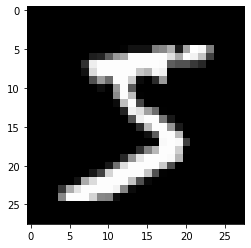

In [7]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

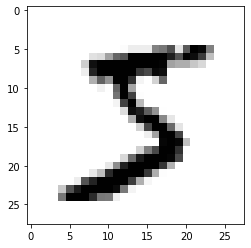

In [8]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

## Batch loading with DataLoader
Our training set contains 60,000 records. If we look ahead to our model we have 784 incoming features, hidden layers of 120 and 84 neurons, and 10 output features. Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\begin{split}\quad(784\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
94080+120+10080+84+840+10 &= 105,214\end{split}$<br>

For this reason it makes sense to load training data in batches using <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [9]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In the cell above, <tt><strong>train_data</strong></tt> is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.

<div class="alert alert-info"><strong>NOTE:</strong> DataLoader takes an optional <tt><strong>num_workers</strong></tt> parameter that sets up how many subprocesses to use for data loading. This behaves differently with different operating systems so we've omitted it here. See <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'>the docs</a> for more information.</div>

### View a batch of images
Once we've defined a DataLoader, we can create a grid of images using <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


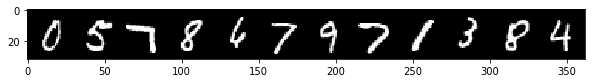

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model
For this exercise we'll use fully connected layers to develop a <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>multilayer perceptron</a>.<br>
Our input size is 784 once we flatten the incoming 28x28 tensors.<br>
Our output size represents the 10 possible digits.<br>
We'll set our hidden layers to [120, 84] for now. Once you've completed the exercise feel free to come back and try different values.

In [11]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [12]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

<div class="alert alert-info"><strong>NOTE:</strong> You may have noticed our shortcut for adding ReLU to the linear layer. In the last section this was done under the <tt>__init__</tt> section as
<pre style='background-color:rgb(217,237,247)'>
layerlist = []
for i in layers:
    layerlist.append(nn.Linear(n_in,i)) 
    layerlist.append(nn.ReLU(inplace=True))
self.layers = nn.Sequential(*layerlist)</pre>
    
Here we're calling <tt>F.relu()</tt> as a functional wrapper on the linear layer directly:
<pre style='background-color:rgb(217,237,247)'>
def forward(self,X):
    X = F.relu(self.fc1(X))</pre></div>

## Count the model parameters
This optional step shows that the number of trainable parameters in our model matches the equation above.

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [14]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


## Define loss function & optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Flatten the training data
The batch tensors fed in by DataLoader have a shape of [100, 1, 28, 28]:

In [16]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


We can flatten them using <tt>.view()</tt>

In [17]:
images.view(100,-1).size() # -1 grab the rest of dimensions and convert them into a single dimension

torch.Size([100, 784])

We'll do this just before applying the model to our data.

## Train the model
This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.

<div class="alert alert-info"><strong>A QUICK NOTE: </strong>In the section below marked &nbsp;<tt><em>#Tally the number of correct predictions</em></tt> &nbsp;we include the code
<pre style='background-color:rgb(217,237,247)'>
predicted = torch.max(y_pred.data, 1)[1]</pre>
This uses the <a href='https://pytorch.org/docs/stable/torch.html#torch.max'><tt><strong>torch.max()</strong></tt></a> function. <tt>torch.max()</tt> returns a tensor of maximum values, and a tensor of the indices where the max values were found. In our code we're asking for the index positions of the maximum values along dimension 1. In this way we can match predictions up to image labels.</div>

In [19]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
    # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        #torch.max(a,1) 返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
        batch_corr = (predicted == y_train).sum()# predicted == y_train returns 1 or 0
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test
            print(y_val)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
          
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.11566461  accuracy:  98.970%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.02571136  accuracy:  98.890%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.04124039  accuracy:  98.890%
tensor([[-1.4635e+01, -1.4250e+01, -9.0878e+00,  ..., -6.6167e-03,
         -1.0122e+01, -8.6814e+00],
        [-1.9106e+01, -1.2022e+01, -1.5855e-05,  ..., -2.8037e+01,
         -1.1541e+01, -3.4334e+01],
        [-1.4648e+01, -1.1505e-03, -9.6562e+00,  ..., -7.8600e+00,
         -7.3808e+00, -1.1685e+01],
        ...,
        [-1.8662e+01, -1.0620e+01, -1.3800e+01,  ..., -1.1206e+01,
         -4.9900e+00, -6.6258e+00],
        [-4.2818e-02, -1.6615e+01, -7.8613e+00,  ..., -1.0258e+01,
         -3.7127e+00, -4.1159e+00],
        [-9.2886e+00, -1.1052e+01, -1.0263e+01,  ..., -1.6180e+01,
         -3.5802e+00, -1.2832e+01]])
tensor([[-3.1967e+01, -2.6018e+01, -2.4263e+01,  ..., -2.2942e+01,
         -1.8105e+01, -1.6681e+01],
        [-1.9448e+01, -3.1226e+01, -1

         -2.0698e+01, -3.2249e+01]])
tensor([[-2.8693e+01, -2.5699e+01, -3.6121e+01,  ..., -3.1402e+01,
         -2.1261e+01, -1.6321e+01],
        [-1.5974e+01, -2.3144e+01, -1.5090e+01,  ..., -2.2822e+01,
         -1.4437e+01, -1.4630e+01],
        [-1.8033e+01, -3.5285e-05, -1.0595e+01,  ..., -1.2750e+01,
         -1.1844e+01, -1.5994e+01],
        ...,
        [-2.0201e+01, -1.1943e+01, -2.2063e+01,  ..., -1.3024e+01,
         -8.2691e+00, -4.6097e+00],
        [-1.7379e+01, -2.5138e+01, -1.8773e+01,  ..., -1.5007e+01,
         -1.0331e+01, -3.5047e-05],
        [-2.2543e+01, -1.8352e+01, -2.2263e+01,  ..., -1.5576e+01,
         -1.7015e+01, -9.7607e+00]])
tensor([[-1.4810e+01, -4.6123e-04, -9.0059e+00,  ..., -1.0411e+01,
         -8.2103e+00, -1.4115e+01],
        [-1.3155e+01, -7.0130e+00, -2.9668e-03,  ..., -7.6976e+00,
         -7.0759e+00, -1.4052e+01],
        [-1.7762e+01, -1.3738e+01, -1.0805e-02,  ..., -1.7677e+01,
         -4.5342e+00, -1.8329e+01],
        ...,
        [

         -1.9868e+01, -1.3021e+01]])
tensor([[-1.4053e+01, -1.7524e+01, -1.4142e+01,  ..., -2.0752e+01,
         -9.5411e+00, -1.9379e+01],
        [-1.1270e+01, -1.3773e+01, -7.4284e+00,  ..., -5.8370e+00,
         -4.5017e+00, -2.7782e-02],
        [-1.5634e+01, -1.8757e+01, -1.3130e+01,  ..., -1.4790e+01,
         -7.6172e-05, -1.3878e+01],
        ...,
        [-1.6339e+01, -1.8031e+01, -1.2647e+01,  ..., -1.1387e+01,
         -1.9931e+01, -9.4128e+00],
        [-1.2484e+01, -1.6103e+01, -1.3737e+01,  ..., -1.9794e-03,
         -1.7075e+01, -6.2297e+00],
        [-1.7895e+01, -2.1273e+01, -1.4176e+01,  ..., -2.1530e+01,
         -2.9802e-06, -1.4105e+01]])
tensor([[-2.9397e+01, -2.4405e+01, -1.8410e+01,  ..., -1.6952e+01,
         -2.0156e+01, -1.2483e+01],
        [-1.6744e+01, -2.1869e+01, -1.9177e+01,  ..., -1.2195e+01,
         -1.2465e+01, -1.4901e-05],
        [-2.4618e+01, -1.8953e+01, -1.6441e+01,  ..., -2.3079e+01,
         -3.3020e-05, -1.5736e+01],
        ...,
        [

         -9.2585e+00, -1.7327e+01]])
tensor([[-26.0874, -13.9868,  -0.0474,  ...,  -3.6444, -13.7828, -23.4411],
        [-29.3847, -25.3052, -24.5928,  ..., -11.1115, -13.1182, -10.5193],
        [-27.3027, -21.3993, -20.2908,  ...,  -8.3772, -16.6941,  -9.2512],
        ...,
        [-23.0539, -24.2412, -25.4096,  ..., -12.8270, -14.0003, -11.5525],
        [-30.4902, -24.5107, -34.3567,  ..., -24.6949, -16.5776, -26.2857],
        [-17.6602, -26.4518, -21.2073,  ..., -26.2105, -23.3247, -25.3276]])
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.01987010  accuracy:  99.425%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.00249315  accuracy:  99.290%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.01019733  accuracy:  99.258%
tensor([[-1.9152e+01, -1.7356e+01, -1.2894e+01,  ..., -1.4782e-05,
         -1.8644e+01, -1.4890e+01],
        [-1.8286e+01, -1.2261e+01, -8.7022e-06,  ..., -2.5378e+01,
         -1.4061e+01, -3.4405e+01],
        [-1.4270e+01, -3.4785e-03, -8.3536e+00,  ..., -6.11

         -2.3773e+01, -1.4761e+01]])
tensor([[-1.3728e+01, -1.7164e+01, -1.4292e+01,  ..., -2.8508e+00,
         -2.1316e+01, -5.9541e-02],
        [-1.8182e+01, -2.3275e+01, -1.7288e+01,  ..., -2.4601e+01,
         -8.5830e-06, -1.6074e+01],
        [-1.7664e+01, -1.8932e+01, -7.1953e+00,  ..., -1.5505e+01,
         -1.7779e+01, -2.6589e+01],
        ...,
        [-1.8331e+01, -1.6398e+01, -3.5763e-07,  ..., -1.6762e+01,
         -1.4953e+01, -2.6273e+01],
        [-1.7421e+01, -2.5653e+01, -1.9377e+01,  ..., -2.9425e+01,
         -2.5665e+01, -2.6395e+01],
        [-3.2100e+01, -2.0968e+01,  0.0000e+00,  ..., -1.7359e+01,
         -2.6920e+01, -3.8392e+01]])
tensor([[-3.1368e+01, -2.8770e+01, -3.9558e+01,  ..., -3.1792e+01,
         -2.3361e+01, -2.0435e+01],
        [-1.6209e+01, -2.4263e+01, -1.3907e+01,  ..., -2.2240e+01,
         -1.5473e+01, -1.5171e+01],
        [-1.9707e+01, -4.7683e-05, -1.0440e+01,  ..., -1.0979e+01,
         -1.3906e+01, -1.9725e+01],
        ...,
        [

         -1.7637e+01, -1.0649e+01]])
tensor([[-1.6939e+01, -7.4221e+00, -3.4042e-02,  ..., -3.4688e+00,
         -1.0643e+01, -1.7671e+01],
        [-2.3294e+01, -1.7167e+01, -1.6897e+01,  ..., -2.1885e+01,
         -1.6453e+01, -1.3787e+01],
        [-3.2304e+01, -2.1173e+01, -1.8729e+01,  ..., -1.9505e+01,
         -1.7036e+01, -2.0952e+01],
        ...,
        [-2.7391e+01, -1.4305e-05, -1.5205e+01,  ..., -1.1971e+01,
         -1.1846e+01, -1.6902e+01],
        [-2.0680e+01, -1.6892e+01, -1.5367e+01,  ..., -1.1825e+01,
         -1.4744e+01, -5.9705e+00],
        [-2.3842e-07, -2.8279e+01, -1.7581e+01,  ..., -1.5875e+01,
         -2.2211e+01, -1.5673e+01]])
tensor([[-1.6302e+01, -1.7627e+01, -1.5741e+01,  ..., -2.0757e+01,
         -1.1097e+01, -2.1560e+01],
        [-1.5847e+01, -1.7517e+01, -1.1163e+01,  ..., -8.8604e+00,
         -5.2177e+00, -1.2568e-02],
        [-1.9378e+01, -2.0028e+01, -1.5780e+01,  ..., -1.6101e+01,
         -1.9525e-04, -1.2383e+01],
        ...,
        [

         -2.5082e+01, -2.1202e+01]])
tensor([[-3.1954e+01, -2.3406e+01, -2.2866e+01,  ...,  0.0000e+00,
         -2.4999e+01, -1.7869e+01],
        [-1.6079e+01, -2.4227e+01, -1.5094e+01,  ..., -2.3777e+01,
         -2.2080e+01, -2.3918e+01],
        [-2.5630e+01, -8.3446e-06, -1.3535e+01,  ..., -1.1942e+01,
         -1.5255e+01, -1.5702e+01],
        ...,
        [-2.2435e+01, -1.7753e+01, -1.9519e+01,  ..., -1.5834e+01,
         -3.4707e+00, -3.1594e-02],
        [ 0.0000e+00, -3.1058e+01, -2.1100e+01,  ..., -2.7391e+01,
         -3.5707e+01, -2.1587e+01],
        [-2.7640e+01, -5.3644e-06, -1.7511e+01,  ..., -1.4359e+01,
         -1.2917e+01, -2.0512e+01]])
tensor([[-32.5004, -14.6227,  -0.1334,  ...,  -2.1197, -19.0289, -30.4782],
        [-37.5751, -27.5801, -29.7210,  ..., -14.2975, -20.5638, -14.9680],
        [-27.8667, -16.7673, -17.0668,  ...,  -1.7244, -14.9641,  -6.9416],
        ...,
        [-30.3611, -26.7787, -31.8663,  ..., -14.3125, -15.9712, -13.9450],
        [-38.8

         -1.2372e+01, -1.3458e+01]])
tensor([[-2.3651e+01, -2.6603e+01, -2.7217e+01,  ..., -1.1539e+01,
         -2.4911e+01, -1.5564e+01],
        [-2.1141e+01, -4.2031e+01, -2.8206e+01,  ..., -3.1558e+01,
         -2.8831e+01, -3.4633e+01],
        [-3.9932e+01, -1.6127e+01, -1.1921e-07,  ..., -1.9596e+01,
         -2.3482e+01, -3.9783e+01],
        ...,
        [-1.7011e+01, -2.6990e+01, -2.5679e+01,  ..., -2.2012e+01,
         -9.8815e+00, -5.4974e-01],
        [-2.0633e+01, -2.6270e-04, -1.3387e+01,  ..., -9.8581e+00,
         -8.6479e+00, -1.1442e+01],
        [-2.4123e+01, -2.4586e+01, -1.5800e+01,  ..., -7.1526e-07,
         -2.6616e+01, -1.4344e+01]])
tensor([[-2.3395e+01, -2.4254e+01, -2.4588e+01,  ..., -9.8676e+00,
         -2.5355e+01, -5.1855e-05],
        [-2.3726e+01, -2.4329e+01, -2.0247e+01,  ..., -2.6806e+01,
         -1.1921e-07, -2.0280e+01],
        [-2.3483e+01, -2.0534e+01, -9.2972e+00,  ..., -1.5656e+01,
         -1.9391e+01, -2.8366e+01],
        ...,
        [

         -1.3656e+01, -1.3386e+01]])
tensor([[-1.8211e+01, -1.8865e+01, -1.4112e+01,  ..., -2.1439e+01,
         -1.2672e+01, -2.3001e+01],
        [-2.1325e+01, -2.6175e+01, -2.5829e+01,  ..., -1.8795e+01,
         -1.9111e+00, -1.1797e+01],
        [-1.5643e+01, -1.7208e+01, -1.8270e+01,  ..., -1.9071e+01,
         -1.3271e+01, -1.8395e+01],
        ...,
        [-3.1383e+01, -2.7813e+01, -3.5037e+01,  ..., -1.9007e+01,
         -9.8982e+00, -1.1086e-04],
        [-3.3671e+01, -2.8718e+01, -2.3577e+01,  ..., -1.9826e+01,
         -2.0633e+01, -1.0877e+01],
        [-2.9608e+01, -1.6977e+01, -1.8433e+01,  ..., -1.7930e+01,
         -2.0987e+01, -1.4846e+01]])
tensor([[-2.0601e+01, -1.0120e+01, -2.8284e-04,  ..., -8.5567e+00,
         -1.2254e+01, -2.4197e+01],
        [-2.4959e+01, -2.0364e+01, -1.9370e+01,  ..., -2.6841e+01,
         -1.7116e+01, -1.5411e+01],
        [-3.5379e+01, -2.5483e+01, -1.9627e+01,  ..., -2.4823e+01,
         -1.7486e+01, -2.5771e+01],
        ...,
        [

         -3.3886e+01, -4.0418e+01]])
tensor([[-4.5256e+01, -3.3971e+01, -3.3786e+01,  ..., -2.5051e+01,
         -3.4257e+01, -2.3911e+01],
        [ 0.0000e+00, -2.6865e+01, -1.9324e+01,  ..., -2.7420e+01,
         -2.9478e+01, -1.9182e+01],
        [-3.5742e+01, -2.5017e+01, -2.6560e+01,  ..., -3.4270e+01,
         -1.1988e+01, -2.1057e+01],
        ...,
        [-2.5058e+01, -2.7069e+01, -2.6106e+01,  ..., -3.4067e+01,
         -2.5885e+01, -3.3653e+01],
        [-2.4763e+01, -2.5141e+01, -2.3529e+01,  ..., -8.8747e+00,
         -1.3253e+01, -2.5329e-04],
        [-4.7684e-07, -2.0675e+01, -1.6434e+01,  ..., -2.4529e+01,
         -2.4503e+01, -2.3895e+01]])
tensor([[-2.9308e+01, -1.9228e+01, -2.1059e+01,  ..., -5.9605e-07,
         -1.9325e+01, -1.5004e+01],
        [-2.1573e+01, -2.8466e+01, -2.2027e+01,  ..., -3.3246e+01,
         -2.9101e+01, -3.3820e+01],
        [-2.5675e+01, -1.0133e-05, -1.1753e+01,  ..., -1.4244e+01,
         -1.3296e+01, -2.1397e+01],
        ...,
        [

         -4.0682e+01, -3.4400e+01]])
tensor([[-3.0128e+01, -2.3150e+01, -2.1528e+01,  ..., -2.0081e+01,
         -1.7055e+01, -1.8981e+01],
        [-2.3279e+01, -3.6084e+01, -2.7387e+01,  ..., -1.8958e+01,
         -1.1487e+01, -1.0371e-05],
        [-3.5263e+01, -3.8642e+01, -3.7667e+01,  ..., -1.6289e+01,
         -2.4110e+01, -1.1921e-07],
        ...,
        [-2.7541e+01, -4.9899e+01, -2.2862e+01,  ..., -3.7932e+01,
         -4.0040e+01, -4.1427e+01],
        [-3.7889e+01, -2.5386e+01, -2.1806e+01,  ...,  0.0000e+00,
         -3.6691e+01, -3.0945e+01],
        [-2.4547e+01, -3.7663e-04, -1.6404e+01,  ..., -7.8994e+00,
         -1.2296e+01, -1.4460e+01]])
tensor([[-2.6485e+01, -3.3080e+01, -2.8457e+01,  ..., -1.8905e+01,
         -3.0549e+01, -2.0180e+01],
        [-2.4682e+01, -4.6880e+01, -2.9002e+01,  ..., -3.9563e+01,
         -3.3860e+01, -3.9618e+01],
        [-4.2983e+01, -2.1591e+01,  0.0000e+00,  ..., -2.5220e+01,
         -2.3347e+01, -4.4914e+01],
        ...,
        [

          0.0000e+00, -3.3465e+01]])
tensor([[-2.2144e+01, -2.0748e-02, -1.1654e+01,  ..., -4.5000e+00,
         -1.1632e+01, -1.1712e+01],
        [-1.8927e+01, -3.6552e+01, -1.8785e+01,  ..., -2.1020e+01,
         -2.4228e+01, -3.5763e-07],
        [-2.5390e+01, -1.1441e+01, -1.5177e+01,  ..., -2.1149e+01,
         -1.7881e-05, -2.2502e+01],
        ...,
        [-3.2276e+01, -2.4281e+01, -2.5857e+01,  ..., -2.9857e+01,
         -1.8788e+01, -1.5655e+01],
        [-2.1815e+01, -2.4853e+01, -1.7061e+01,  ..., -1.4361e+01,
         -1.9525e+01, -8.3446e-06],
        [-3.3104e+01, -3.2814e+01, -3.8740e+01,  ..., -2.9078e+01,
         -1.8527e+01, -1.4670e+01]])
tensor([[-1.6401e+01, -1.6935e+01, -1.2304e+01,  ..., -1.8637e+01,
         -1.0344e+01, -1.9940e+01],
        [-3.0276e+01, -3.4271e+01, -3.7787e+01,  ..., -2.3813e+01,
         -1.1301e+01, -1.6276e+01],
        [-1.4382e+01, -1.8363e+01, -1.7938e+01,  ..., -1.8670e+01,
         -1.2788e+01, -1.6580e+01],
        ...,
        [

          0.0000e+00, -2.6537e+01]])
tensor([[-4.0512e+01, -4.4798e+01, -3.1982e+01,  ..., -3.1268e+01,
         -6.4631e+01, -4.1131e+01],
        [-4.4749e+01, -4.1584e+01, -4.8473e+01,  ..., -2.1263e+01,
         -2.9968e+01,  0.0000e+00],
        [-3.2759e+01, -2.7577e+01, -4.0047e+01,  ..., -2.0819e+01,
         -2.3588e+01,  0.0000e+00],
        ...,
        [-3.1026e+01, -1.5523e+01, -9.2965e+00,  ..., -1.7521e-02,
         -1.5279e+01, -2.1169e+01],
        [-3.8090e+01, -1.5493e+01, -9.5367e-07,  ..., -2.4841e+01,
         -2.3831e+01, -4.2414e+01],
        [-2.7621e+01, -4.8698e+01, -2.6531e+01,  ..., -3.9384e+01,
         -3.4687e+01, -3.8810e+01]])
tensor([[-5.9227e+01, -4.4729e+01, -5.0471e+01,  ..., -3.1554e+01,
         -4.5294e+01, -2.8458e+01],
        [ 0.0000e+00, -3.4506e+01, -2.4628e+01,  ..., -3.1598e+01,
         -3.7706e+01, -2.0818e+01],
        [-3.2442e+01, -2.4249e+01, -2.6815e+01,  ..., -3.1203e+01,
         -1.3783e+01, -1.6737e+01],
        ...,
        [

         -1.2085e+01, -2.3545e+01]])
tensor([[-1.6113e+01, -8.9158e-02, -1.1614e+01,  ..., -7.7026e+00,
         -4.8285e+00, -2.5758e+00],
        [-3.5684e+01, -2.7098e+01, -2.7822e+01,  ..., -3.5736e+01,
         -2.5153e+01, -2.4460e+01],
        [-3.8572e+01, -3.8324e+01, -3.7390e+01,  ..., -2.8183e+01,
         -2.9246e+01, -1.1921e-07],
        ...,
        [-1.4276e+01, -9.4387e+00, -1.1830e-01,  ..., -2.0834e+01,
         -3.1995e+00, -3.3817e+01],
        [-2.6656e+01, -2.6284e+01, -2.5421e+01,  ..., -1.5946e+01,
         -2.1835e+01, -1.3336e+01],
        [ 0.0000e+00, -3.4158e+01, -3.3175e+01,  ..., -3.6955e+01,
         -3.8827e+01, -4.0946e+01]])
tensor([[-3.7195e+01, -2.6009e+01, -2.5808e+01,  ..., -2.3273e+01,
         -1.5897e+01, -2.5043e+01],
        [-2.7524e+01, -3.9622e+01, -3.1148e+01,  ..., -1.9226e+01,
         -1.2216e+01, -5.6028e-06],
        [-3.8764e+01, -4.1190e+01, -3.9847e+01,  ..., -1.7641e+01,
         -2.5261e+01, -2.3842e-07],
        ...,
        [

         -2.0817e+01, -7.5102e-06]])
tensor([[-2.5439e+01, -2.0294e+01, -2.8743e+01,  ..., -1.7453e+01,
         -2.5625e+01,  0.0000e+00],
        [-1.1921e-07, -2.7411e+01, -1.9716e+01,  ..., -2.4165e+01,
         -2.6630e+01, -1.7704e+01],
        [-3.2919e+01, -2.0179e+01, -7.1526e-07,  ..., -2.1051e+01,
         -1.4338e+01, -3.8103e+01],
        ...,
        [-2.8966e+01, -3.2260e+01, -1.9462e+01,  ...,  0.0000e+00,
         -3.3838e+01, -2.1261e+01],
        [-3.2391e+01, -1.8852e+01, -1.5005e+01,  ..., -4.7684e-07,
         -1.6350e+01, -1.6289e+01],
        [-3.0799e+01, -3.5647e+01, -2.0537e+01,  ..., -2.9804e+01,
          0.0000e+00, -2.8307e+01]])
tensor([[-2.0600e+01, -6.8665e-02, -1.0191e+01,  ..., -2.8197e+00,
         -1.1026e+01, -1.0283e+01],
        [-1.5204e+01, -3.2219e+01, -1.3826e+01,  ..., -2.0718e+01,
         -1.7009e+01, -1.0490e-05],
        [-1.7655e+01, -8.4354e+00, -1.0766e+01,  ..., -1.4712e+01,
         -9.7037e-04, -1.8484e+01],
        ...,
        [

          0.0000e+00, -2.4954e+01]])
tensor([[-4.4547e+01, -4.3406e+01, -3.0242e+01,  ..., -3.4973e+01,
         -6.2251e+01, -4.0053e+01],
        [-4.2030e+01, -4.1799e+01, -4.5699e+01,  ..., -2.5703e+01,
         -2.9343e+01,  0.0000e+00],
        [-3.1238e+01, -2.8141e+01, -3.7553e+01,  ..., -2.3829e+01,
         -2.4338e+01,  0.0000e+00],
        ...,
        [-2.8645e+01, -1.8559e+01, -7.4670e+00,  ..., -2.8828e-02,
         -7.6567e+00, -2.2153e+01],
        [-4.1679e+01, -1.5863e+01, -1.1921e-07,  ..., -2.2334e+01,
         -2.4057e+01, -4.2294e+01],
        [-2.3855e+01, -4.6652e+01, -2.3794e+01,  ..., -3.8403e+01,
         -3.1840e+01, -3.4407e+01]])
tensor([[-5.0452e+01, -3.9690e+01, -4.1810e+01,  ..., -3.3959e+01,
         -3.8060e+01, -2.1874e+01],
        [ 0.0000e+00, -3.2236e+01, -2.3159e+01,  ..., -3.1736e+01,
         -3.5647e+01, -1.9157e+01],
        [-3.9834e+01, -3.7102e+01, -3.5241e+01,  ..., -4.0708e+01,
         -1.9629e+01, -2.1526e+01],
        ...,
        [

## Plot the loss and accuracy comparisons

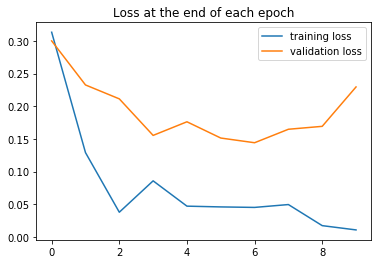

In [21]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

This shows some evidence of overfitting the training data.

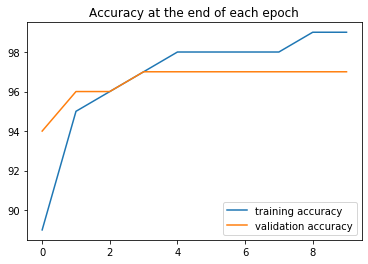

In [22]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data
We retained the test scores during our training session:

In [23]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9439), tensor(9635), tensor(9666), tensor(9715), tensor(9745), tensor(9757), tensor(9746), tensor(9775), tensor(9765), tensor(9723)]

Test accuracy: 97.230%


However, we'd like to compare the predicted values to the ground truth (the y_test labels), so we'll run the test set through the trained model all at once.

In [24]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [25]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9723/10000 =  97.230%


Not bad considering that a random guess gives only 10% accuracy!

## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [26]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    5    0    4    2    6    0    5    1]
 [   0 1122    2    0    0    0    3    4    0    3]
 [   2    4 1004    5    5    0    3   10    2    0]
 [   2    1    4  981    0    2    1    4    8    4]
 [   0    0    1    0  956    1    2    1    3    7]
 [   2    1    1   13    0  882   35    0   18    7]
 [   0    2    2    0    2    0  904    0    1    0]
 [   2    1    4    5    3    2    3 1002    5   10]
 [   1    4    9    2    1    2    1    1  926    1]
 [   1    0    0    4   11    1    0    6    6  976]]


This shows that the model had the greatest success with ones, twos and sevens, and the lowest with fives, sixes and eights.

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [27]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

277

In [28]:
# Display the first 10 index positions
misses[:10]

array([  20,  115,  151,  217,  247,  259,  321,  381,  386,  445],
      dtype=int64)

In [29]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [ 882  938  947  951  956  965 1014 1039 1050 1112 1128 1153]
Label: [   9    3    8    5    1    6    6    7    2    4    3    6]
Guess: [   7    5    9    4    2    0    5    2    3    6    7    5]


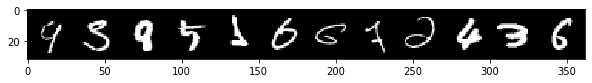

In [33]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Great job!